In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
# Import data
decks = pd.read_csv('data.csv')
cards = pd.read_json('refs.json')
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Let's only use Ranked Decks.
decks = pd.DataFrame(decks)
decks['deck_type'] = decks['deck_type'].astype('str') 
Ranked = pd.DataFrame(decks.loc[decks["deck_type"] == "Ranked Deck"])
Ranked['year'] = Ranked['date'].astype(str).str[0:4]
import matplotlib.patches as mpatches
from pylab import plot, show, savefig, xlim, figure, hold, ylim, legend, boxplot, setp, axes
# Use this to find decks with any hint of popularity
Ranked2 = Ranked[Ranked["rating"] >= 5]
Ranked2['deck_class'].apply(str) 
Ranked['year'].apply(str) 
Ranked['deck_class'].apply(str) 
Ranked['year'].apply(str) 
classes = list(Ranked['deck_class'][Ranked['year'] == '2017'].value_counts(sort=False).index)

In [4]:
# Get the card names here:
CARD_DATA = cards[['dbfId',"name","rarity","playerClass"]]
# get the name of each card, for example:
CARD_DATA[CARD_DATA["dbfId"] == 192]["name"].value_counts(sort=False).index[0]

'Ice Block'

Association Networks of popular cards used in the Gadgetzan Set, by Class


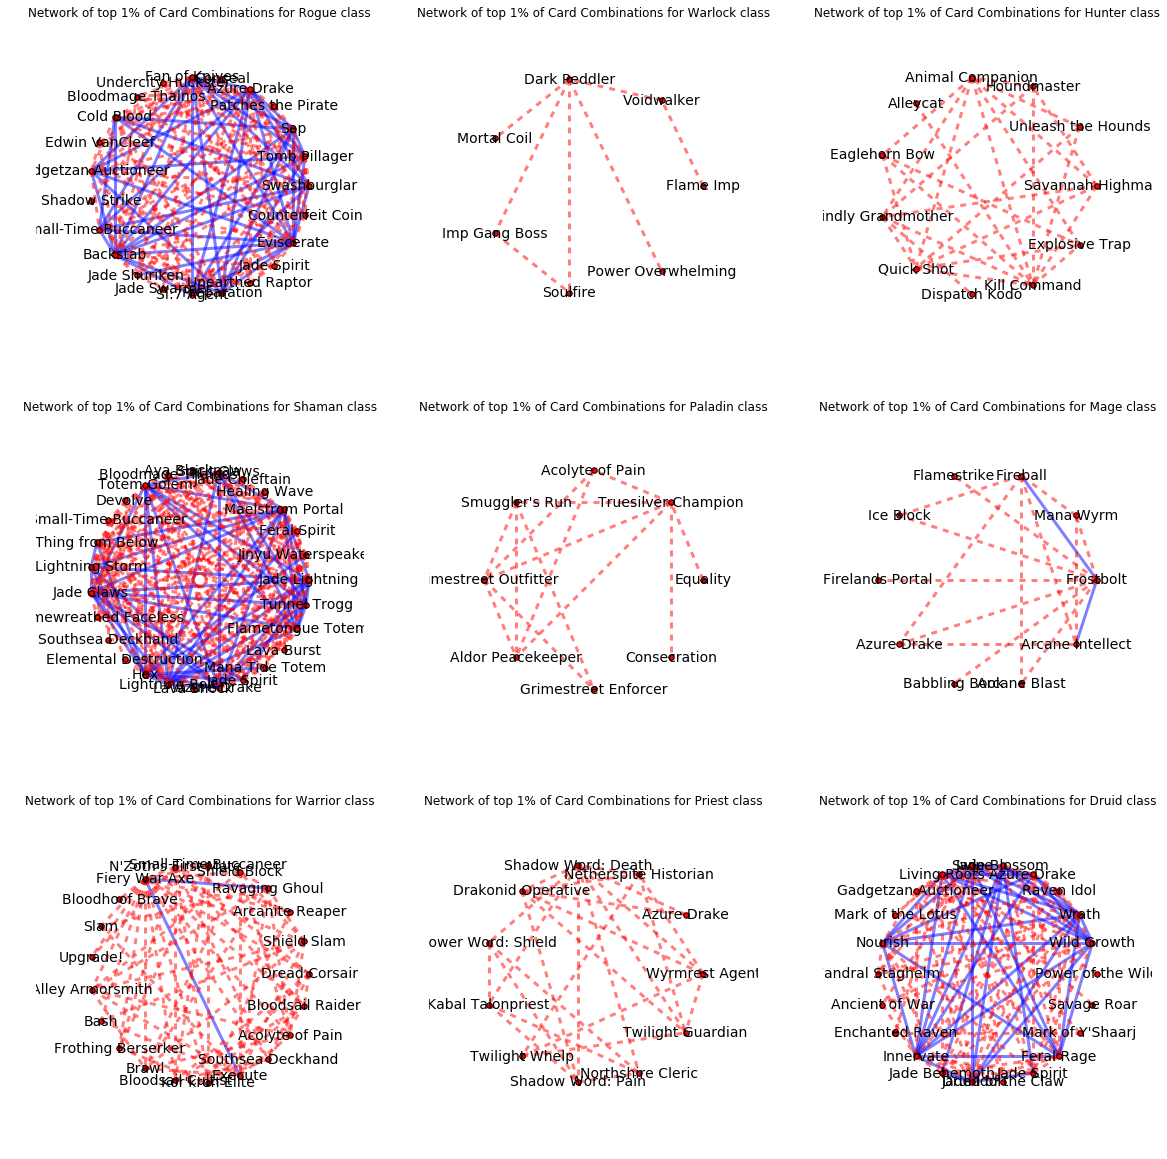

Association Networks of popular cards used in the Blackrock Launch Set, by Class


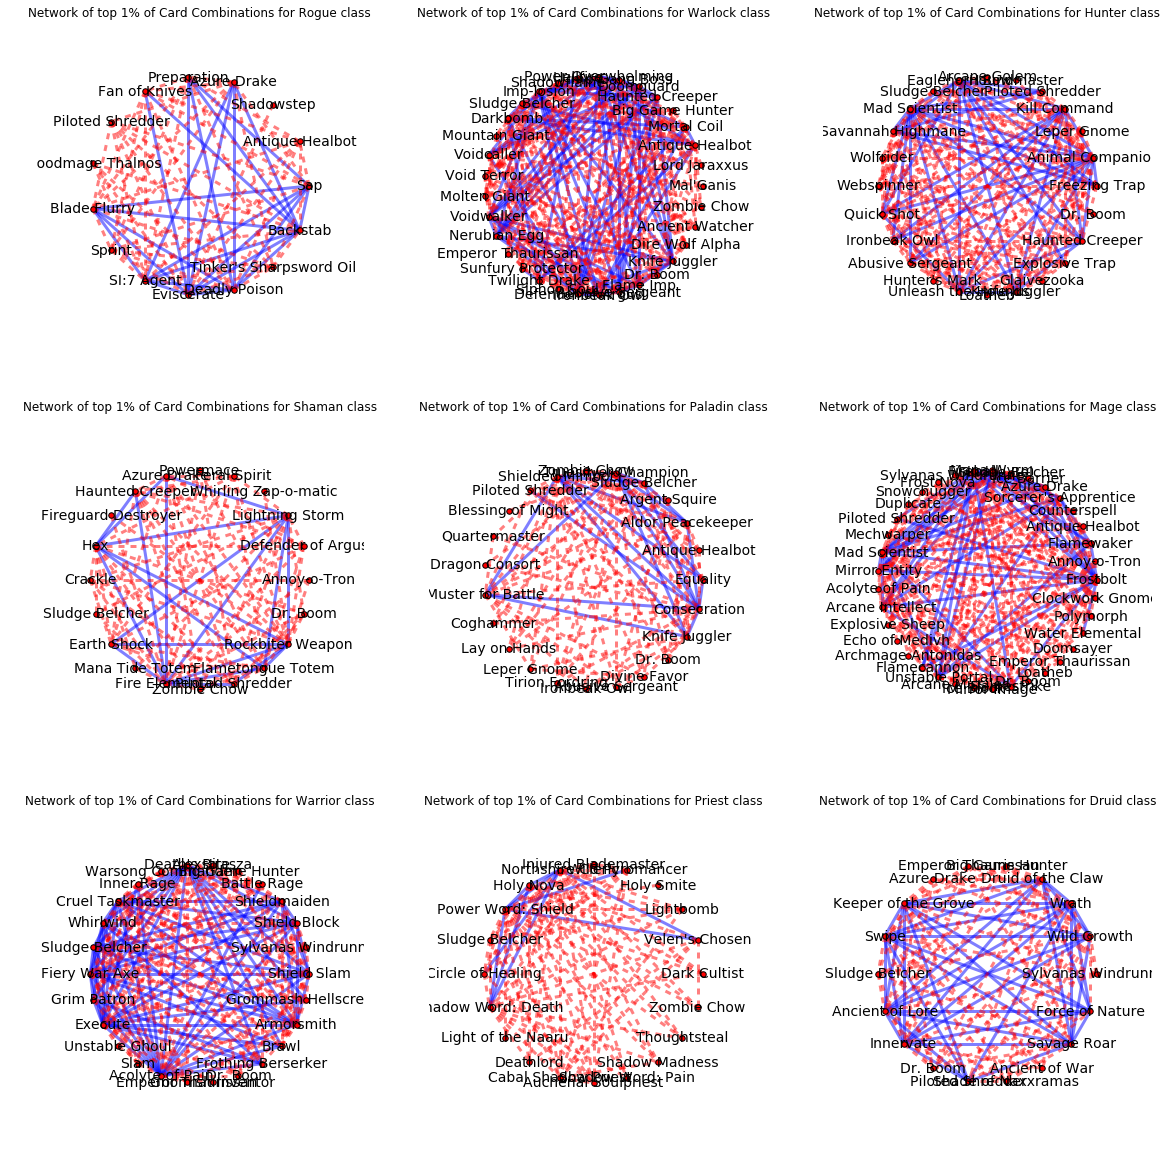

In [10]:
# Make a Network of popular Used Card Combinations 
# How often are cards used together in decks?
from collections import defaultdict
def counting_cards(list_of_full_deck,deck_card_combos,total_card_counts):
    for m in range(len(list_of_full_deck)):
        G = list(sorted(list_of_full_deck[m]))
        for i in G:
            if str(i) not in total_card_counts:
                total_card_counts[str(i)] = 1
            else:
                total_card_counts[str(i)] += 1
            for j in G:
                if i !=j:
                    temp = (str(i), str(j))
                    if temp not in deck_card_combos:
                        deck_card_combos[temp] = 1
                    else:
                        deck_card_combos[temp] += 1
    return deck_card_combos, total_card_counts

def Deck_class_structing(current_set,i):
    Current_Deck = pd.DataFrame(current_set[current_set["deck_class"] == str(i)])
    list_of_full_deck = []
    deck_card_combos = defaultdict(int) # this is for the pairs
    total_card_counts = defaultdict(int)
    for j in range(len(Current_Deck)):
        this_deck = []
        for k in range(30):
            card = "card_" + str(k)
            this_deck.append(Current_Deck[card].iloc[j])
        list_of_full_deck.append(this_deck)
    return list_of_full_deck, deck_card_combos, total_card_counts

def graph_network(class_default_dict_counts,i):
    G=nx.Graph()
    min_node_count = len(class_default_dict_counts)/100 # 1% of the interactions.
    for key in class_default_dict_counts:
        if class_default_dict_counts[key] > min_node_count:
            G.add_edge(CARD_DATA[CARD_DATA["dbfId"] == float(key[0])]["name"].value_counts(sort=False).index[0],
                       CARD_DATA[CARD_DATA["dbfId"] == float(key[1])]["name"].value_counts(sort=False).index[0], 
                       weight = np.log(class_default_dict_counts[key]))    
    elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >np.log(min_node_count*2)]
    esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=np.log(min_node_count*2)]
    pos=nx.circular_layout(G) # positions for all nodes
    # nodes
    nx.draw_networkx_nodes(G,pos,node_size=30)
    # edges
    # Maybe, make the edges fray as they get less strong?
    nx.draw_networkx_edges(G,pos,edgelist=elarge,width=3,alpha=0.5,edge_color='blue' )
    nx.draw_networkx_edges(G,pos,edgelist=esmall,width=3,alpha=0.5,edge_color='red',style='dashed')
    # labels
    nx.draw_networkx_labels(G,pos,font_size=14,font_color = "black", font_family='sans-serif')
    plt.axis('off')
    plt.title("Network of top 1% of Card Combinations for "+i + " class")

# Make 2 plots of 9 subplots
def Make_networks_for_each_class(Set, save_file_name):
    fig = figure(figsize = (20,20))
    x = 1
    print("Association Networks of popular cards used in the "+Set+" Set, by Class")
    Set = Make_Set_from_string(Set)
    class_default_dict_counts = [] # this is for the pairs
    total_cards_by_class = []
    for i in classes:
        plt.subplot(330+x)
        plt.title("Most used card combinations in set")
        x+=1
        temp_stuff = Deck_class_structing(Set,i)
        A = counting_cards(temp_stuff[0],temp_stuff[1],temp_stuff[2])
        class_default_dict_counts.append(A[0])
        total_cards_by_class.append(A[1])
        graph_network(A[0],i)
    savefig(save_file_name)
    plt.show()


def Make_Set_from_string(text):
    Set = pd.DataFrame(Ranked[(Ranked["rating"]>5) & (Ranked['deck_set'] == str(text))])
    return Set
# We'll show a 'late' set, and a much earlier set to highlight the differences 
# in inter-related card combinations for decks.
Make_networks_for_each_class("Gadgetzan", 'data_plot2_1.png')
Make_networks_for_each_class("Blackrock Launch", 'data_plot2_2.png')